# Hacer

- Separar día/mes de fecha
- Codificar variables categóricas

### Definiciones

- Encoding de etiquetas: Día de la semana, se puede ordenar
- Binary encoding: Resto

## Usar

- Regresión lineal
- Árbol de decisión

https://chatgpt.com/share/671b97fb-7904-8006-853c-7d28072ea3c5

- Algún método no supervisado?

In [17]:

# Se importan librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error # Se deprecó mean_squared_error y se cambió por root_mean_squared_error
import category_encoders as ce
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn import datasets

In [30]:
# Función para procesar los dataset
def procesar_dataset(filepath):
    # Carga del dataset
    dataset = pd.read_csv(filepath)

    # Se eliminan las filas que contienen "Otros" en la columna "tipo_cobro"
    # Se toma esta decisión porque su impacto es mínimo
    dataset = dataset[dataset["tipo_cobro"] != "Otros"]

    # Se separa el día y el mes del año en columnas separadas
    # Necesitamos que las variables sean numéricas
    dataset["nro_dia"] = pd.to_datetime(dataset["fecha"]).dt.day
    dataset["nro_mes"] = pd.to_datetime(dataset["fecha"]).dt.month
    dataset["anio"] = pd.to_datetime(dataset["fecha"]).dt.year
    dataset.drop("fecha", axis=1, inplace=True)

    # Se codifica la categoría día de la semana con label encoding (codificación de etiquetas)
    # Se toma esta decisión porque la variable es ordinal
    day_encoding = {
        'Lunes': 0,
        'Martes': 1,
        'Miercoles': 2,
        'Jueves': 3,
        'Viernes': 4,
        'Sabado': 5,
        'Domingo': 6
    }

    dataset['dia_semana'] = dataset['dia'].map(day_encoding)
    dataset.drop("dia", axis=1, inplace=True)

    # Se codifica el resto de las variables categóricas con binary encoding (codificación binaria)
    binary_encoder = ce.BinaryEncoder(cols=["id_peaje", "sentido", "tipo_vehiculo", "tipo_cobro"])
    dataset = binary_encoder.fit_transform(dataset)
    # Eliminamos las columnas sentido_1 y tipo_vehiculo_1 porque no aportan información
    dataset.drop(["sentido_1", "tipo_vehiculo_1"], axis=1, inplace=True)
    # Cambiarle el nombre a las columnas sentido y tipo_vehículo para saber qué significa cada valor
    dataset.rename(columns={'sentido_0': 'hacia_provincia'}, inplace=True)
    dataset.rename(columns={'tipo_vehiculo_0': 'es_pesado'}, inplace=True)
    return dataset

In [21]:
dataset = procesar_dataset("clean_data.csv")
dataset.sample(10)
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4473491 entries, 0 to 4473490
Data columns (total 17 columns):
 #   Column           Dtype  
---  ------           -----  
 0   hora             float64
 1   id_peaje_0       int64  
 2   id_peaje_1       int64  
 3   id_peaje_2       int64  
 4   hacia_provincia  int64  
 5   sentido_1        int64  
 6   es_pesado        int64  
 7   tipo_vehiculo_1  int64  
 8   tipo_cobro_0     int64  
 9   tipo_cobro_1     int64  
 10  tipo_cobro_2     int64  
 11  tipo_cobro_3     int64  
 12  pasos            int64  
 13  nro_dia          int32  
 14  nro_mes          int32  
 15  anio             int32  
 16  dia_semana       int64  
dtypes: float64(1), int32(3), int64(13)
memory usage: 529.0 MB


In [22]:
# Cambiarle el nombre a las columnas sentido y tipo_vehículo para saber qué significa cada valor
dataset.rename(columns={'sentido_0': 'hacia_provincia'}, inplace=True)
dataset.rename(columns={'tipo_vehiculo_0': 'es_pesado'}, inplace=True)

# Regresión lineal

In [23]:
# Dividir en variables predictoras (X) y variable objetivo (y)
# Ver la razón por la que dejando 'pasos' se reduce mucho el error
x = dataset[['hora', 'id_peaje_0', 'id_peaje_1', 'id_peaje_2', 'hacia_provincia', 'es_pesado', 'tipo_cobro_0', 'tipo_cobro_1', 'tipo_cobro_2', 'tipo_cobro_3','pasos', 'nro_dia', 'nro_mes', 'anio', 'dia_semana']]  
y = dataset['pasos'] 

# Dividir en conjunto de entrenamiento y de prueba
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=50)

# Instanciar el modelo
linear_model = LinearRegression()

# Entrenar el modelo
linear_model.fit(x_train, y_train)

# Predecir sobre el conjunto de prueba
y_pred = linear_model.predict(x_test)

# Evaluar el modelo
mse = root_mean_squared_error(y_test, y_pred) ** 2
print("Error cuadrático medio de la regresión lineal múltiple:", mse)


Error cuadrático medio de la regresión lineal múltiple: 5.8178698472134245e-22


In [19]:
# Cargar los datos desde los archivos
dataset_train = procesar_dataset("clean_data.csv")
dataset_test = procesar_dataset("2024_data.csv")

# Separar las variables predictoras (X) y la variable objetivo (y) para el conjunto de entrenamiento
x_train = dataset_train[['hora', 'id_peaje_0', 'id_peaje_1', 'id_peaje_2', 'hacia_provincia', 'es_pesado', 
                         'tipo_cobro_0', 'tipo_cobro_1', 'tipo_cobro_2', 'tipo_cobro_3',  'pasos',
                         'nro_dia', 'nro_mes', 'anio', 'dia_semana']]  
y_train = dataset_train['pasos']

# Separar las variables predictoras (X) y la variable objetivo (y) para el conjunto de prueba
x_test = dataset_test[['hora', 'id_peaje_0', 'id_peaje_1', 'id_peaje_2', 'hacia_provincia', 'es_pesado',
                       'tipo_cobro_0', 'tipo_cobro_1', 'tipo_cobro_2', 'tipo_cobro_3', 'pasos',
                       'nro_dia', 'nro_mes', 'anio', 'dia_semana']]  
y_test = dataset_test['pasos']
x_test.dropna(inplace=True)
y_test = y_test[x_test.index]
linear_model = LinearRegression()

# Entrenar el modelo
linear_model.fit(x_train, y_train)

# Predecir sobre el conjunto de prueba
y_pred = linear_model.predict(x_test)


C:\Users\Guadalupe\AppData\Local\Temp\ipykernel_23612\3638064688.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test.dropna(inplace=True)


Error cuadrático medio de la regresión lineal múltiple: 1.5310130130981274e-22
Error cuadrático medio de la regresión lineal múltiple: 1.2373411062023792e-11


## Métricas del modelo entrenado

Error cuadrático medio de la regresión lineal múltiple: 5.8178698472134245e-22
Error cuadrático medio de la regresión lineal múltiple: 2.412026087589731e-11
Raíz del Error Cuadrático Medio (RMSE): 2.412026087589731e-11
Error Absoluto Medio (MAE): 1.347287129777581e-11
Coeficiente de Determinación (R²): 1.0
Error Absoluto Medio Porcentual (MAPE): 1.833568692616758e-10


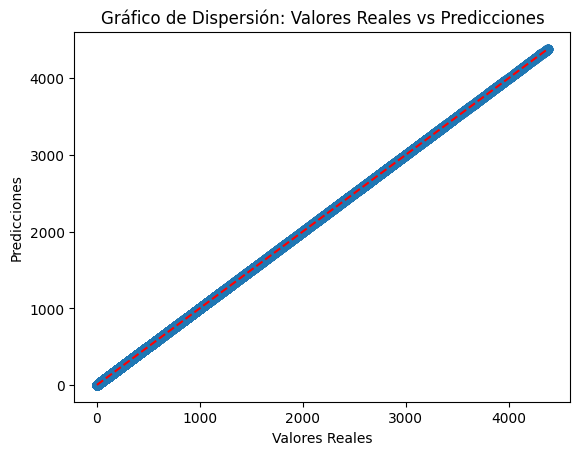

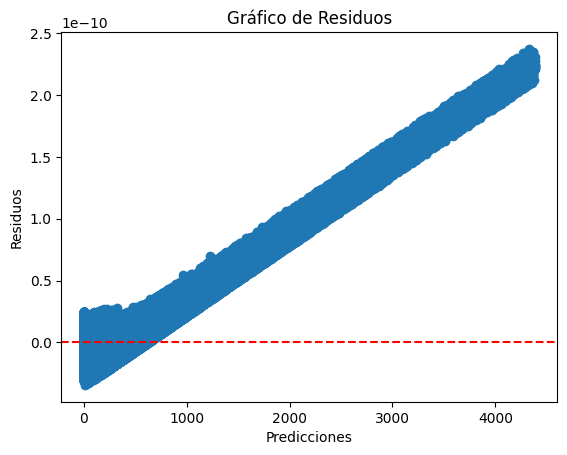

In [24]:
# Evaluar el modelo
mse = mean_squared_error(y_test, y_pred)
mse1 = root_mean_squared_error(y_test, y_pred)
print("Error cuadrático medio de la regresión lineal múltiple:", mse)
print("Error cuadrático medio de la regresión lineal múltiple:", mse1)

# Raíz del Error Cuadrático Medio (RMSE - Root Mean Squared Error)
rmse = np.sqrt(mse)

# Error Absoluto Medio (MAE - Mean Absolute Error)
mae = mean_absolute_error(y_test, y_pred)

# R² (Coeficiente de Determinación):
r2 = r2_score(y_test, y_pred)

# Error Absoluto Medio Porcentual (MAPE - Mean Absolute Percentage Error)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

# Imprimir las métricas
print("Raíz del Error Cuadrático Medio (RMSE):", rmse)
print("Error Absoluto Medio (MAE):", mae)
print("Coeficiente de Determinación (R²):", r2)
print("Error Absoluto Medio Porcentual (MAPE):", mape)


plt.scatter(y_test, y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Línea de identidad
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.title('Gráfico de Dispersión: Valores Reales vs Predicciones')
plt.show()

# Gráfico de Residuos (Residual Plot). Muestra los residuos (diferencias entre los valores reales y las predicciones) en función de las predicciones.
residuals = y_test - y_pred

plt.scatter(y_pred, residuals)
plt.axhline(y=0, color='r', linestyle='--')  # Línea en y=0
plt.xlabel('Predicciones')
plt.ylabel('Residuos')
plt.title('Gráfico de Residuos')
plt.show()

## Predicción del modelo respecto al 2024

c:\Users\Guadalupe\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


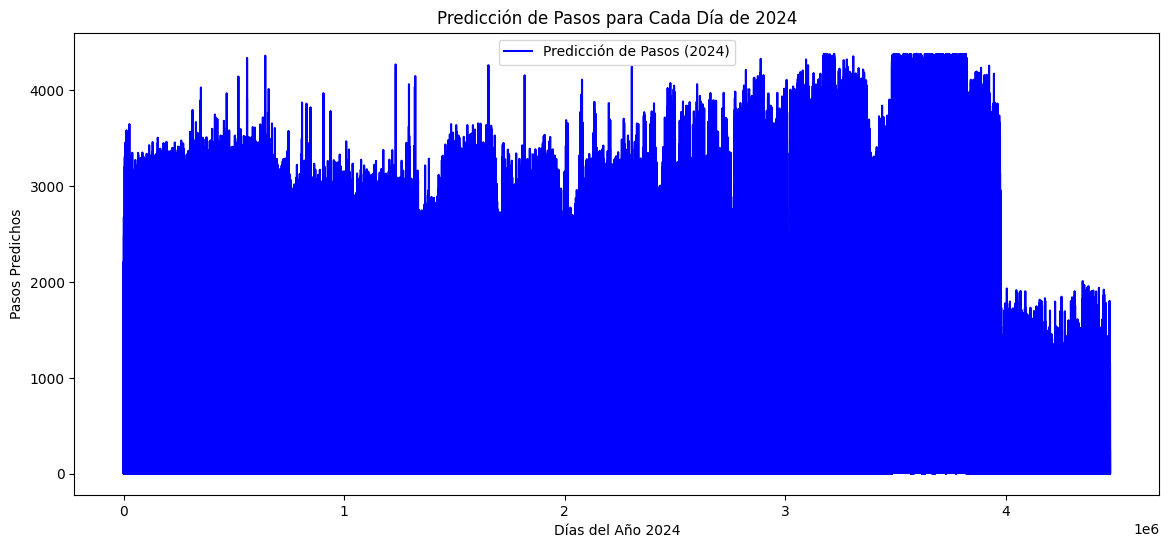

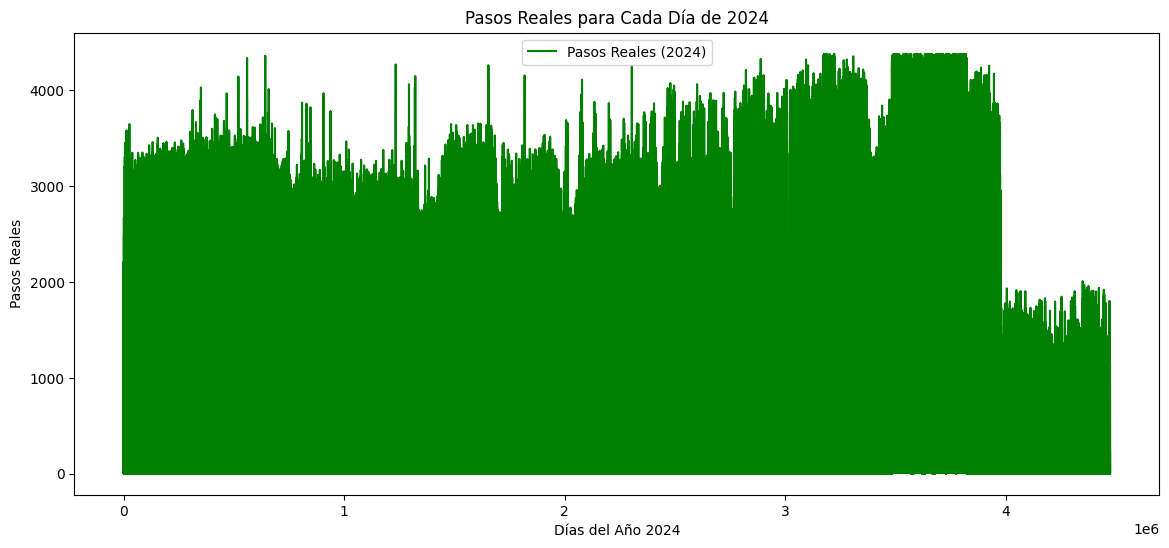

Error Cuadrático Medio (MSE) en 2024: 5.812146623148955e-22
Error Absoluto Medio (MAE) en 2024: 1.3459665229042134e-11


In [34]:
# TODO HAY ALGO MAL PORQUE ME DIERON EXACTAMENTE IGUAL

dataset_2024 = procesar_dataset("2024_data.csv")
# Se eliminan algunos nulos que hayan quedado
dataset_2024 = dataset.dropna()

# Separar las variables predictoras (X) y la variable objetivo (y)
x_2024 = dataset_2024[['hora', 'id_peaje_0', 'id_peaje_1', 'id_peaje_2', 'hacia_provincia', 'es_pesado', 'tipo_cobro_0', 'tipo_cobro_1', 'tipo_cobro_2', 
                       'tipo_cobro_3','pasos', 'nro_dia', 'nro_mes', 'anio', 'dia_semana']]  
y_real_2024 = dataset_2024['pasos']

# Realizar las predicciones para cada día del 2024 usando el modelo entrenado previamente
y_pred_2024 = linear_model.predict(x_2024)

# Visualización de las predicciones
plt.figure(figsize=(14, 6))
plt.plot(y_pred_2024, label="Predicción de Pasos (2024)", color='blue')
plt.title("Predicción de Pasos para Cada Día de 2024")
plt.xlabel("Días del Año 2024")
plt.ylabel("Pasos Predichos")
plt.legend()
plt.show()

# Visualización de los datos reales del 2024
plt.figure(figsize=(14, 6))
plt.plot(y_real_2024.values, label="Pasos Reales (2024)", color='green')
plt.title("Pasos Reales para Cada Día de 2024")
plt.xlabel("Días del Año 2024")
plt.ylabel("Pasos Reales")
plt.legend()
plt.show()

# Evaluación del modelo para el 2024
mse_2024 = mean_squared_error(y_real_2024, y_pred_2024)
mae_2024 = mean_absolute_error(y_real_2024, y_pred_2024)
print(f"Error Cuadrático Medio (MSE) en 2024: {mse_2024}")
print(f"Error Absoluto Medio (MAE) en 2024: {mae_2024}")